In [1]:
import numpy as np
import pandas as pd
import os 
import json
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
DOMAINS_NAMES = ['news', 'politics', 'music', 'science', 'literature', 'ai']
baseline = 'rs5000'
model = 'rs5001'

In [7]:
def preprocess_true_data():
    domains = ['news', 'politics', 'music', 'science', 'literature', 'ai']

    merged_data = []
    json_files = []
    for domain in domains:
        path = f'../baseline/crossre_data/{domain}-test.json'
        json_files.append(path)

    for file in json_files:
        tmp_data = []
        with open(file) as f:
            for line in f:
                tmp_data.append(line)
            merged_data.append(tmp_data)
            
    return merged_data 


news, politics, music, science, literature, ai = preprocess_true_data()
DOMAINS = [news, politics, music, science, literature, ai]


In [9]:
real_labels_per_domain = []
base_labels_per_domain = []
model_labels_per_domain = []
base_scores_per_domain = []
model_scores_per_domain = []

for index,domain in enumerate(DOMAINS_NAMES):
    base_path = f'../baseline/experiments/{baseline}/{domain}-test-pred.csv'
    model_path = f'../baseline/experiments/{model}/{domain}-test-pred.csv'
    base_results_path = f'../baseline/experiments/{baseline}/{domain}-test-pred-results.json'
    model_results_path = f'../baseline/experiments/{model}/{domain}-test-pred-results.json'

    base_df = pd.read_csv(base_path)
    model_df = pd.read_csv(model_path)

    current_domain = DOMAINS[index]

    real_labels, base_labels, model_labels = [], [], []
    unique_labels, unique_labels_model = [], []
    scores = {}

    base_results = pd.read_json(base_results_path)
    model_results = pd.read_json(model_results_path)
    base_scores_per_domain.append(base_results)
    model_scores_per_domain.append(model_results)
    

    i = 0 
    for obj in current_domain:
        obj = json.loads(obj)
        relations = obj['relations']
        if relations == []:
            continue

        sentence = obj['sentence']
        for ind, relation in enumerate(relations):
            if relation[0] != relation[2] and relation[1] != relation[3]:
                if ind > 0:
                    if relations[ind][0] == relations[ind-1][0] and relations[ind][1] == relations[ind-1][1] and relations[ind][2] == relations[ind-1][2] and relations[ind][3] == relations[ind-1][3]:
                        continue
                
                relation_label_real = relation[4]
                if relation_label_real not in unique_labels:
                    unique_labels.append(relation_label_real)
                

                current_label = base_df['labels'][i]
                current_model_label = model_df['labels'][i]
                real_labels.append(relation_label_real)
                base_labels.append(current_label)
                model_labels.append(current_model_label)

                if current_model_label not in unique_labels_model:
                    unique_labels_model.append(current_model_label)
                if relation_label_real not in unique_labels_model:
                    unique_labels_model.append(relation_label_real)

                
                current_sentence = base_df['text'][i]

                i += 1
            

    real_labels_per_domain.append(real_labels)
    base_labels_per_domain.append(base_labels)
    model_labels_per_domain.append(model_labels)
    real_labels = []


In [10]:
def custom_confusion_matrix(y_true, y_pred, ax, title, plot=True):
    assert len(y_true) == len(y_pred), "Lengths of true and predicted labels must be equal."
    
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

    for t, p in zip(y_true, y_pred):
        true_index = np.where(unique_labels == t)[0][0]
        pred_index = np.where(unique_labels == p)[0][0]
        confusion_matrix[true_index, pred_index] += 1

    if plot:
        sns.set(font_scale=1.2)
        heatmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels, ax=ax)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_title(f'Confusion Matrix: {title}')

        return heatmap, confusion_matrix
    else:
        return _, confusion_matrix

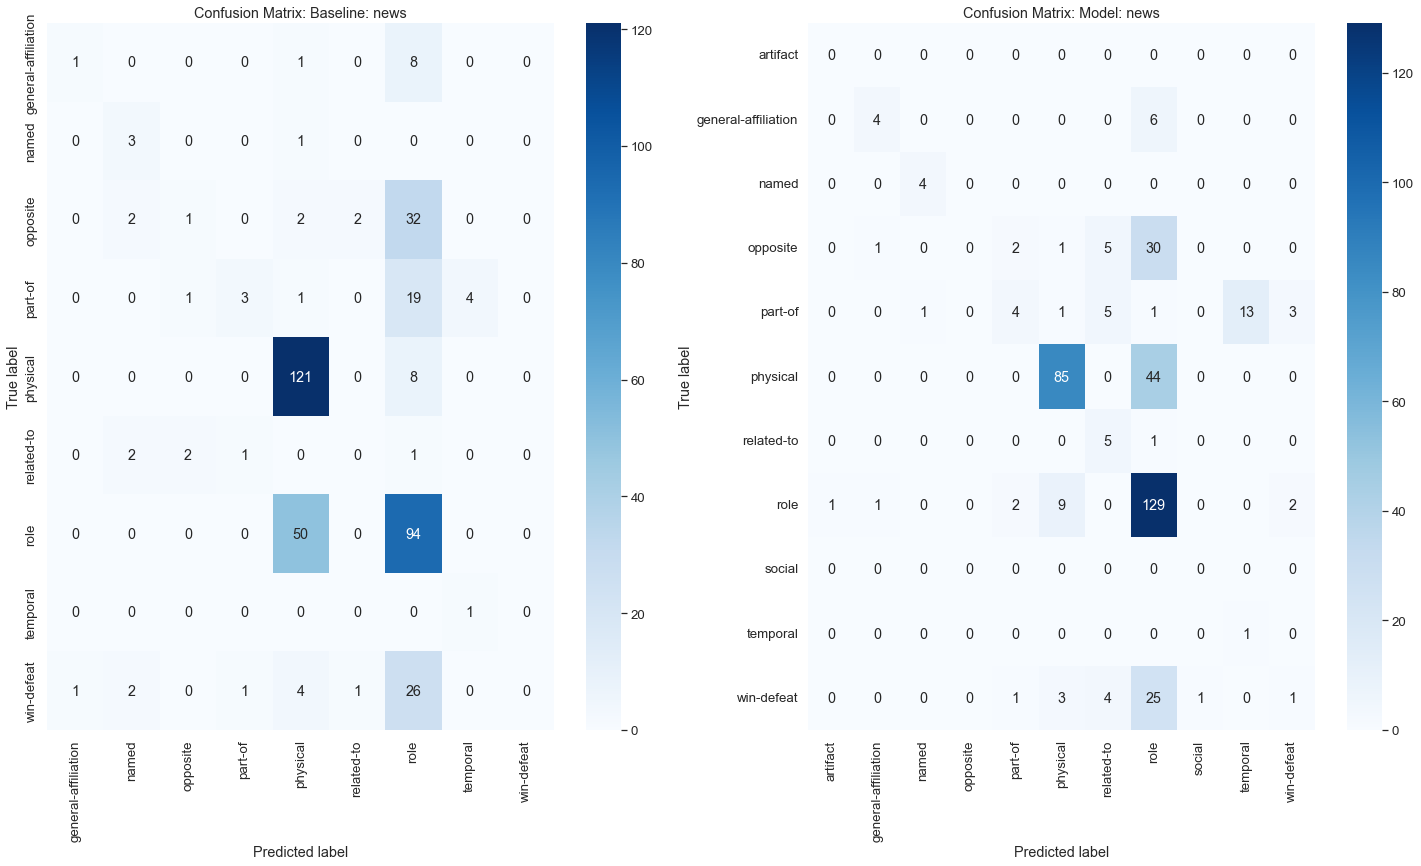

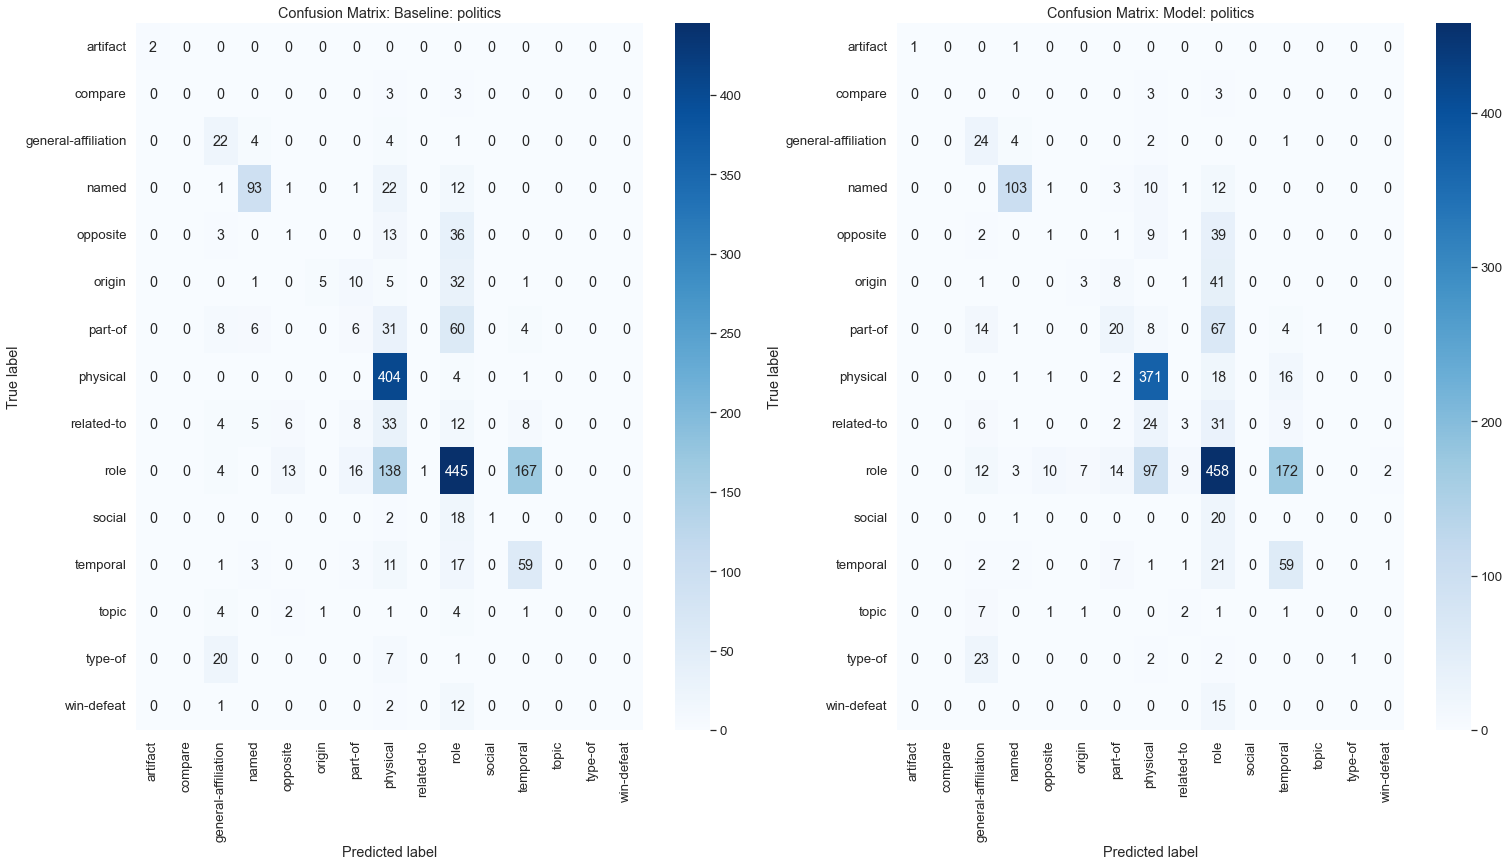

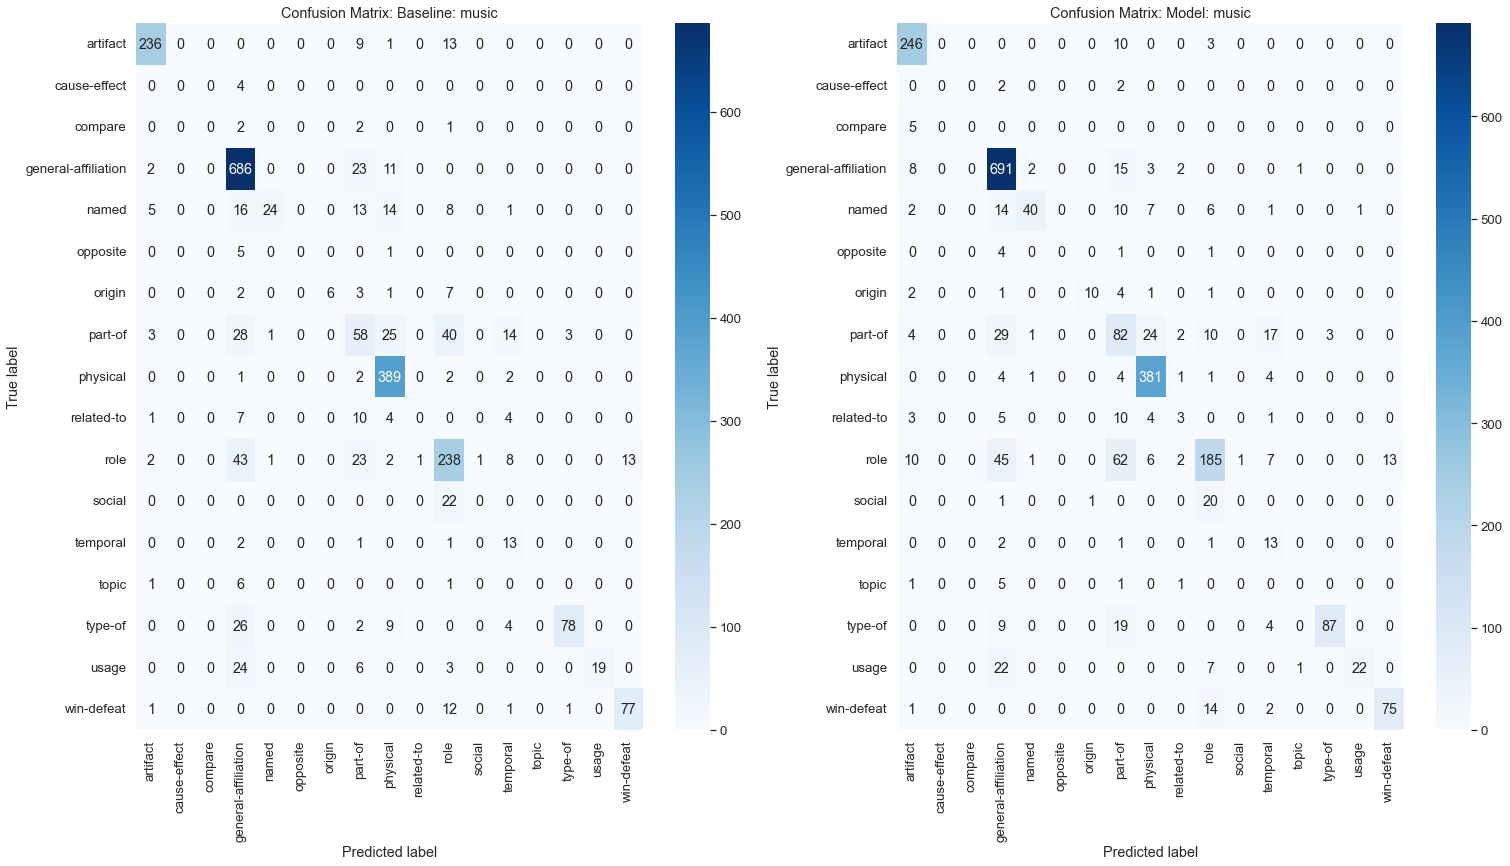

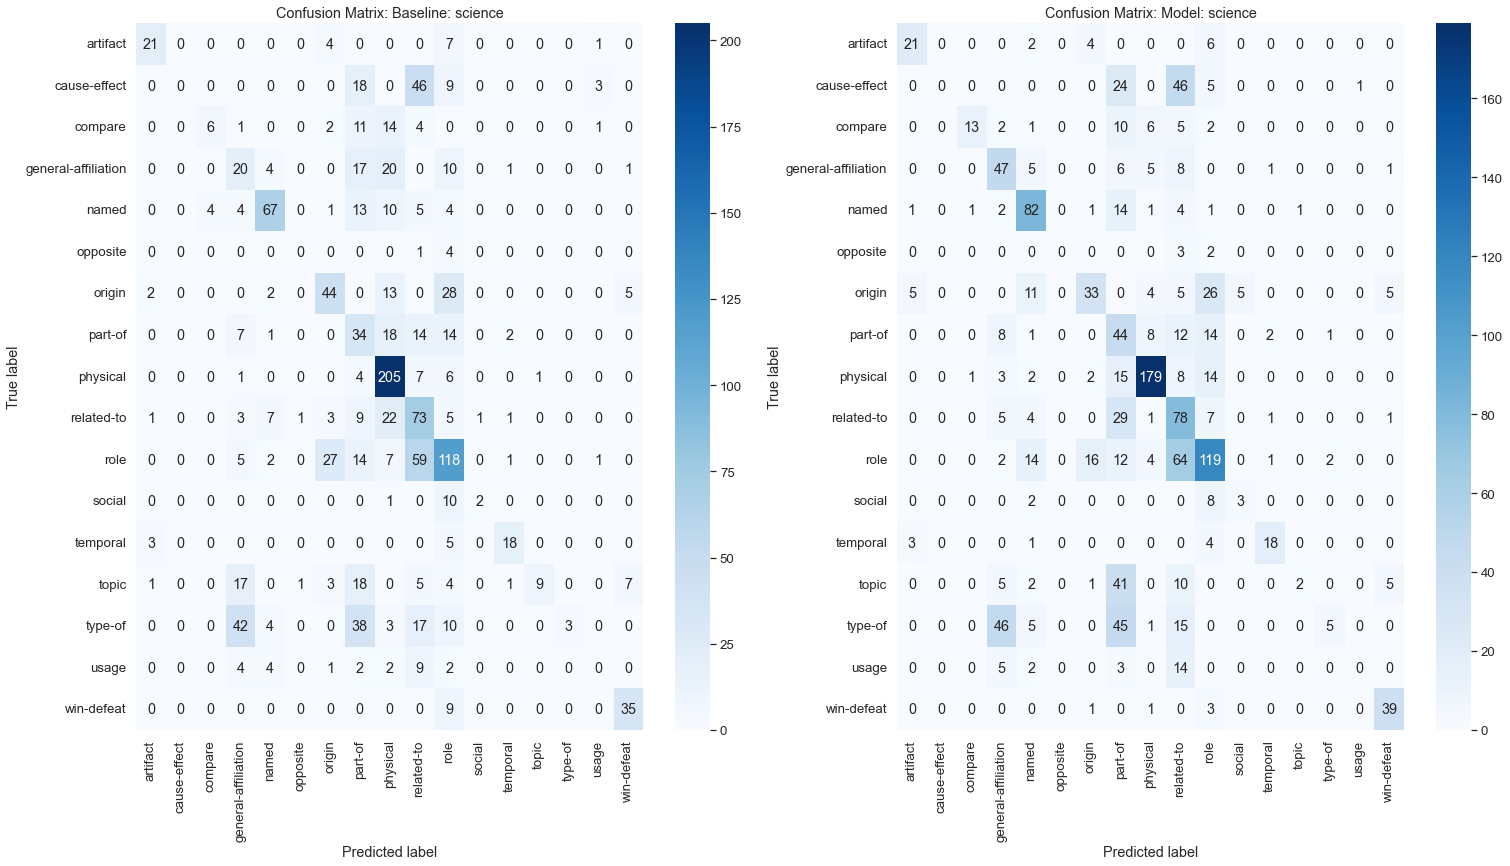

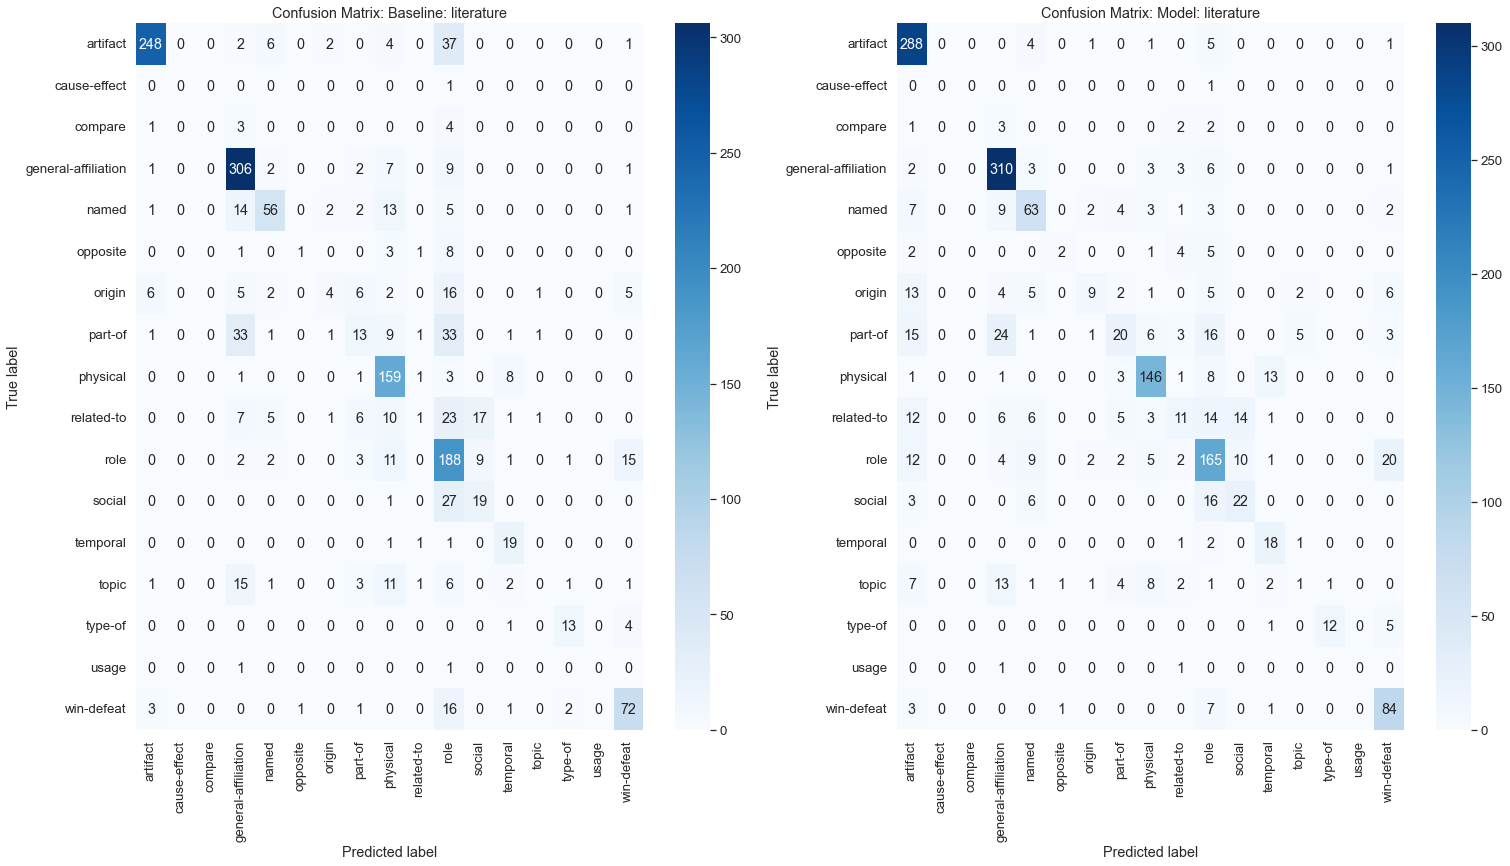

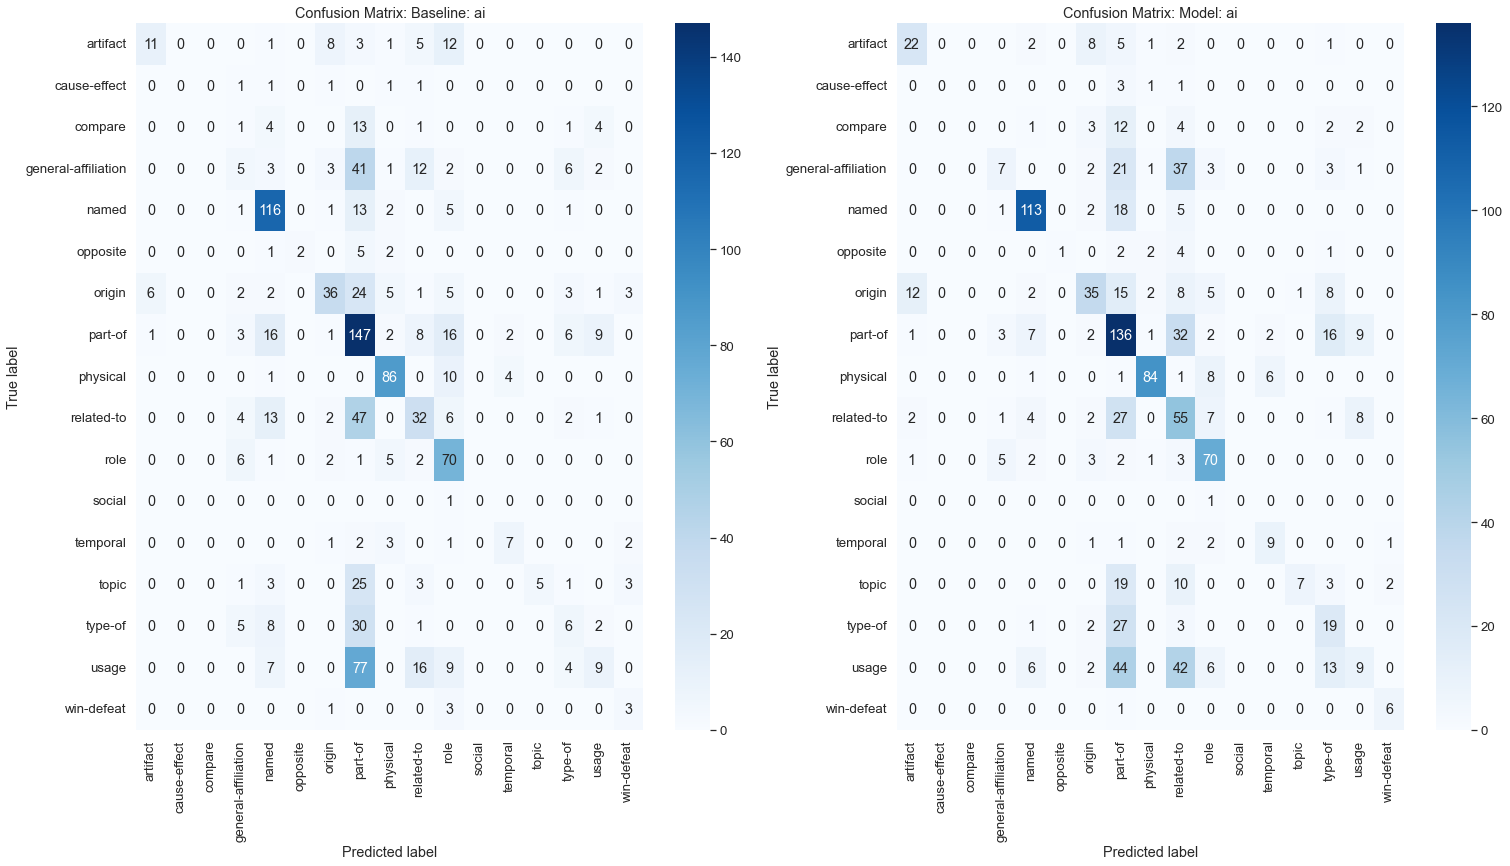

In [12]:
def print_domain_evaluation(domain):
    domain_idx = DOMAINS_NAMES.index(domain)

    rl = real_labels_per_domain[domain_idx]
    bl = base_labels_per_domain[domain_idx]
    ml = model_labels_per_domain[domain_idx]
    base_scores = base_scores_per_domain[domain_idx]
    model_scores = model_scores_per_domain[domain_idx]


    custom_confusion_matrix(rl, bl, ax[0], f'Baseline: {domain}')
    custom_confusion_matrix(rl, ml, ax[1], f'Model: {domain}')

for domain in DOMAINS_NAMES:
    fig, ax = plt.subplots(figsize=(25,13), nrows=1, ncols=2)
    print_domain_evaluation(domain)



In [15]:
unique_labels = []
base_final_results = []
model_final_results = []
base_final_recall = []
model_final_recall = []
for domain in DOMAINS_NAMES:
    domain_idx = DOMAINS_NAMES.index(domain)

    rl = real_labels_per_domain[domain_idx]
    bl = base_labels_per_domain[domain_idx]
    ml = model_labels_per_domain[domain_idx]
    base_scores = base_scores_per_domain[domain_idx]
    model_scores = model_scores_per_domain[domain_idx]

    for label in rl:
        if label not in unique_labels:
            unique_labels.append(label)
    for label in bl:
        if label not in unique_labels:
            unique_labels.append(label)
    for label in ml:
        if label not in unique_labels:
            unique_labels.append(label)

    base_results_path = f'../baseline/experiments/{baseline}/{domain}-test-pred-results.json'
    model_results_path = f'../baseline/experiments/{model}/{domain}-test-pred-results.json'

    base_results_df = pd.read_json(base_results_path)
    model_results_df = pd.read_json(model_results_path)

    #base_results_df_only_precision - where index = precision
    row = base_results_df.loc['precision']
    base_final_results.append(row)

    row = model_results_df.loc['precision']
    model_final_results.append(row)

    row = base_results_df.loc['recall']
    base_final_recall.append(row)

    row = model_results_df.loc['recall']
    model_final_recall.append(row)



prec_df_base = pd.DataFrame(base_final_results, columns=unique_labels, index=DOMAINS_NAMES)
prec_df_model = pd.DataFrame(model_final_results, columns=unique_labels, index=DOMAINS_NAMES)

df_difference = prec_df_model - prec_df_base
pd.set_option('display.float_format', '{:.1f}'.format)


rec_df_base = pd.DataFrame(base_final_recall, columns=unique_labels, index=DOMAINS_NAMES)
rec_df_model = pd.DataFrame(model_final_recall, columns=unique_labels, index=DOMAINS_NAMES)
df_rec_difference = rec_df_model - rec_df_base

In [16]:
df_difference = df_difference.T * 100
df_difference

,news,politics,music,science,literature,ai
win-defeat,16.7,33.3,-0.3,3.6,-3.3,39.4
physical,18.6,10.6,4.6,20.2,13.7,9.8
role,4.7,-3.4,-0.4,12.5,15.5,18.3
named,46.7,5.0,-3.4,-12.4,-10.4,15.8
part-of,-15.6,21.5,-2.3,-1.0,14.9,6.8
related-to,26.3,16.7,27.3,-1.7,18.8,-12.7
opposite,-25.0,2.8,0.0,0.0,0.0,0.0
temporal,-12.9,-3.4,2.6,3.3,-3.0,-0.5
general-affiliation,16.7,-6.0,2.3,18.4,4.2,23.9
artifact,0.0,0.0,-6.8,-5.0,-16.0,-3.2


In [15]:
df_rec_difference = df_rec_difference.T / 100
df_rec_difference

,news,politics,music,science,literature,ai
win-defeat,0.0,0.0,-0.0,0.0,0.0,0.0
physical,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
role,0.0,0.0,-0.0,0.0,-0.0,-0.0
named,0.0,0.0,0.0,0.0,0.0,-0.0
part-of,0.0,0.0,0.0,0.0,0.0,-0.0
related-to,0.0,0.0,0.0,0.0,0.0,0.0
opposite,-0.0,0.0,0.0,0.0,0.0,-0.0
temporal,0.0,0.0,0.0,0.0,0.0,0.0
general-affiliation,0.0,0.0,0.0,0.0,0.0,0.0
artifact,0.0,-0.0,0.0,0.0,0.0,0.0


In [17]:
df_difference.to_csv('precision_diff.csv')
df_rec_difference.to_csv('recall_diff.csv')